In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.datasets import load_iris
from collections import Counter
sns.set()

In [3]:
from copy import deepcopy

In [6]:
iris=load_iris()

In [7]:
features=iris['data']
target=iris['target']

In [64]:
num_f=features.shape[1]

In [10]:
ranges

{0: [0.2, 5.1], 1: [0.2, 4.9], 2: [0.2, 4.7], 3: [0.2, 4.6]}

In [69]:
classes=sorted(list(set(target)))
cl={c:i for i,c in enumerate(classes)}
def distribution(x,y):
    dist_count={f: np.zeros((x.shape[0],x.shape[1]+1)) for f in range(num_f)}
    for f in dist_count:
        idx=np.argsort(x[:,f],axis=0)
        dist_count[f][:,-1]=idx
        target_sort=y[idx]
        z=np.zeros(num_f)
        for i,t in enumerate(target_sort):
            j=cl[t]
            z[j]+=1
            dist_count[f][i][:-1]=z
    return dist_count

In [32]:
def best_split(x):
    arr1=x.copy()
    arr2=x.copy()
    arr2=arr2[-1]-arr2
    
    arr1=arr1/arr1.sum(1).reshape(-1,1)
    s=arr2.sum(1).reshape(-1,1)
    s[-1][0]=1
    arr2=arr2/s
    arr1=np.where(arr1==0,1,arr1)
    arr2=np.where(arr2==0,1,arr2)
    
    entropy1=-arr1*np.log2(arr1)
    entropy1=entropy1.sum(1)
    entropy2=-arr2*np.log2(arr2)
    entropy2=entropy2.sum(1)
    
    total=entropy1+entropy2
    return total.argmin(),total.min()

In [102]:
class BST:
    def __init__(self,value):
        self.head=value
        self.right=None
        self.left=None
        
    def insert(self,value):
        if value>self.head:
            if self.right==None:
                self.right=BST(value)
            else:
                return self.right.insert(value)
        else:
            if self.left==None:
                self.left=BST(value)
            else:
                return self.left.insert(value)
    
    def read_all(self,node):
        if node is not None:
            print(node.head)
            self.read_all(node.right)
            self.read_all(node.left)
        if node is None:
            pass

In [103]:
bst=BST(2)

In [104]:
bst.head

2

In [105]:
bst.insert(4)

In [108]:
bst.insert(1)

In [110]:
bst.insert(18)

In [113]:
bst.insert(3)

In [114]:
bst.read_all(bst)

2
4
18
3
1


In [153]:
class Node:
    def __init__(self,cl_dic,feature=None,idx=None,depth=None):
        self.feature=feature # (feature_num, threshold)
        self.idx_subset=idx
        self.depth=depth
        self.ent=None
        self.cl_dic=cl_dic
        self.right=None
        self.left=None
    
    def entropy(self,y):
        subset=y[self.idx_subset]
        z=np.zeros(len(self.cl_dic))
        for t in subset:
            k=self.cl_dic[t]
            z[k]+=1
        z=z/z.sum()
        z=np.where(z==0,1,z)
        ent=-z*np.log2(z)
        ent=ent.sum()
        
        return ent
        
    def entropy_split(self,x):
        
        z=x.copy()
        w=x.copy()
        
        w=w/w.sum(1).reshape(-1,1)
        w=np.where(w==0,1,w)
        entropy1=-w*np.log2(w)
        entropy1=entropy1.sum(1)
        
        z=z[-1]-z
        s=z.sum(1).reshape(-1,1)
        s[-1][0]=1
        z=z/s
        z=np.where(z==0,1,z)
        
        entropy2=-z*np.log2(z)
        entropy2=entropy2.sum(1)
        total=entropy1+entropy2
        j=total.argmin()
        
        return j,entropy1[j],entropy2[j]
    
    def best_feature(self,x,y):
        
        w=np.zeros(x.shape[1])
        indices=[]
        pos=[]
        values=[]
        for f in range(x.shape[1]):
            idx=np.argsort(x[:,f],axis=0)
            indices.append(idx.copy())
            y_sort=y[idx]
            z=np.zeros((x.shape[0],len(self.cl_dic)))
            cum=np.zeros(z.shape[1])
            for i,t in enumerate(y_sort):
                k=self.cl_dic[t]
                cum[k]+=1
                z[i]=cum[:]
            j,e1,e2=self.entropy_split(z)
            pos.append(j)
            w[f]=e1+e2
            values.append(x[idx][j,f])
            
        num=w.argmin()
        idx=indices[num]
        j=pos[num]
        
        return num,values[num],idx[:j],idx[j:]
    
    def split(self,node,x,y):
        if node is not None:
            self.ent=self.entropy(y)
            if self.ent==0:
                pass
        if node is not None and node.feature is None:
            #split
            idx=node.idx_subset
            a,b,idl,idr=self.best_feature(x[idx],y[idx])
            node.feature=(a,b)
            node.right=Node(idx=idr,depth=node.depth+1,cl_dic=node.cl_dic)
            node.left=Node(idx=idl,depth=node.depth+1,cl_dic=node.cl_dic)
        elif node is not None and node.feature is not None:
            #go down on tree
            self.split(node.right,x,y)
            self.split(node.left,x,y)

In [160]:
class DTreeClassifier:
    def __init__(self,criterion='entropy',depth=None):
        self.criterion='entropy'
        print('Using entropy criterion')
        self.max_depth=depth
        self.classes=None
        self.num_features=None
        self.head=None
        
    def fit(self,x,y):
        self.classes=sorted(list(set(y)))
        self.num_features=x.shape[1]
        cl_dic={c:i for i,c in enumerate(self.classes)}
        idx=np.arange(x.shape[0])
        
        self.head=Node(cl_dic=cl_dic,idx=idx,depth=0)
        
        for i in range(self.max_depth):
            self.head.split(self.head,x,y)

In [167]:
DT=DTreeClassifier(depth=3)

Using entropy criterion


In [168]:
DT.fit(features,target)

IndexError: index -1 is out of bounds for axis 0 with size 0

In [166]:
DT.head.ent

1.584962500721156

In [159]:
DT.head.

In [33]:
entropy=[]
for f,arr in edcount.items():
    a=best_split(arr)
    entropy.append(a)

In [34]:
entropy

[(15, 1.5634074323981904), (143, 1.5824207639595795), (49, 1.0), (49, 1.0)]

In [55]:
entropy2=[]
for f,arr in edcount.items():
    ar=arr-arr[49]
    a=best_split(ar[50:])
    entropy2.append(a)

In [57]:
entropy2

[(2, 1.2046986815511866),
 (3, 1.4526617925582568),
 (50, 0.5687795371177298),
 (53, 0.5961618275679523)]

In [48]:
idx=np.argsort(features[:,3],axis=0)
target[idx]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import matplotlib.pyplot as plt

In [17]:
dtree=DecisionTreeClassifier()

In [18]:
dtree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': None,
 'splitter': 'best'}

In [41]:
dtree.max_depth=2
dtree.criterion='entropy'

In [42]:
dtree.fit(features,target)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

[Text(133.92000000000002, 181.2, 'X[3] <= 0.8\nentropy = 1.585\nsamples = 150\nvalue = [50, 50, 50]'),
 Text(66.96000000000001, 108.72, 'entropy = 0.0\nsamples = 50\nvalue = [50, 0, 0]'),
 Text(200.88000000000002, 108.72, 'X[3] <= 1.75\nentropy = 1.0\nsamples = 100\nvalue = [0, 50, 50]'),
 Text(133.92000000000002, 36.23999999999998, 'entropy = 0.445\nsamples = 54\nvalue = [0, 49, 5]'),
 Text(267.84000000000003, 36.23999999999998, 'entropy = 0.151\nsamples = 46\nvalue = [0, 1, 45]')]

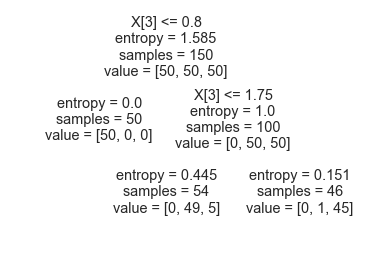

In [43]:
tree.plot_tree(dtree)

In [58]:
0.445+0.151

0.596

In [59]:
49/(49+5)*np.log2(49/(49+5))+5/(49+5)*np.log2(5/(49+5))

-0.44506485705083865

In [60]:
1/(45+1)*np.log2(1/(45+1))+45/(45+1)*np.log2(45/(45+1))

-0.15109697051711368

In [61]:
0.44506485705083865+0.15109697051711368

0.5961618275679523